In [1]:
from gym.wrappers import RescaleAction, TimeLimit
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO, TD3
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

from environments import ARESEAOneStep, ARESEASequential

## Sequential

In [5]:
run_name = "bright-rain-963"
log_dir = f"models/{run_name}"

def make_env():
    env = ARESEASequential(
        backend="simulation",
        random_incoming=True,
        random_initial=True,
        beam_parameter_method="direct"
    )
    env = TimeLimit(env, max_episode_steps=50)
    env = RescaleAction(env, -1, 1)
    return env

env = DummyVecEnv([make_env])
env = VecNormalize.load(f"{log_dir}/vec_normalize.pkl", env)
env.training = False
env.norm_reward = False

model = TD3.load(f"{log_dir}/model")

Initial: [4.33153572e-03 2.36067286e-05 4.13556121e-03 7.00088367e-03]
Achieved: [0.00074047 0.00135207 0.00051541 0.00036935]
Desired: [0.00074728 0.00133953 0.00042614 0.00036015]
Delta: [ 6.81035234e-06 -1.25374293e-05 -8.92709338e-05 -9.20434167e-06]
Objective: -8.43885193390575


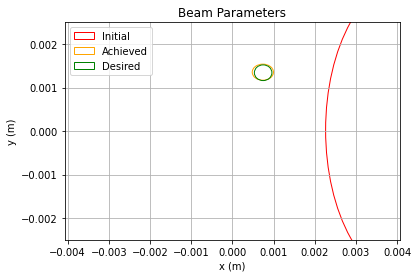

In [6]:
observation = env.reset()
desired = env.unnormalize_obs(observation)[0,-8:-4]
initial = env.unnormalize_obs(observation)[0,-4:]
done = False
while not done:
    action, _ = model.predict(observation, deterministic=True)
    observation, reward, done, info = env.step(action)
achieved = env.unnormalize_obs(info[0]["terminal_observation"])[-4:]

print("Initial:", initial)
print("Achieved:", achieved)
print("Desired:", desired)
print("Delta:", desired - achieved)
print("Objective:", env.unwrapped.envs[0].unwrapped._objective_fn(achieved, desired))

screen = env.get_attr("accelerator")[0].segment.AREABSCR1
plt.title("Beam Parameters")
plt.xlim([screen.extent[0], screen.extent[1]])
plt.ylim([screen.extent[2], screen.extent[3]])
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid()
plt.gca().add_patch(Ellipse((initial[0],initial[1]), initial[2], initial[3], fill=False, color="red", label="Initial"))
plt.gca().add_patch(Ellipse((achieved[0],achieved[1]), achieved[2], achieved[3], fill=False, color="orange", label="Achieved"))
plt.gca().add_patch(Ellipse((desired[0],desired[1]), desired[2], desired[3], fill=False, color="green", label="Desired"))
plt.legend()
plt.show()

In [7]:
def evaluate(run_name, n=100):
    log_dir = f"models/{run_name}"

    def make_env():
        env = ARESEASequential(
            backend="simulation",
            random_incoming=True,
            random_initial=True,
            beam_parameter_method="direct"
        )
        env = TimeLimit(env, max_episode_steps=50)
        env = RescaleAction(env, -1, 1)
        return env

    env = DummyVecEnv([make_env])
    env = VecNormalize.load(f"{log_dir}/vec_normalize.pkl", env)
    env.training = False
    env.norm_reward = False

    model = TD3.load(f"{log_dir}/model")

    objectives = []
    mses = []
    for _ in range(n):
        observation = env.reset()
        desired = env.unnormalize_obs(observation)[0,-8:-4]
        done = False
        while not done:
            action, _ = model.predict(observation, deterministic=True)
            observation, reward, done, info = env.step(action)
        achieved = env.unnormalize_obs(info[0]["terminal_observation"])[-4:]
        objective = env.unwrapped.envs[0].unwrapped._objective_fn(achieved, desired)
        objectives.append(objective)
        mse = ((desired - achieved)**2).mean()
        mses.append(mse)
    
    return objectives, mses

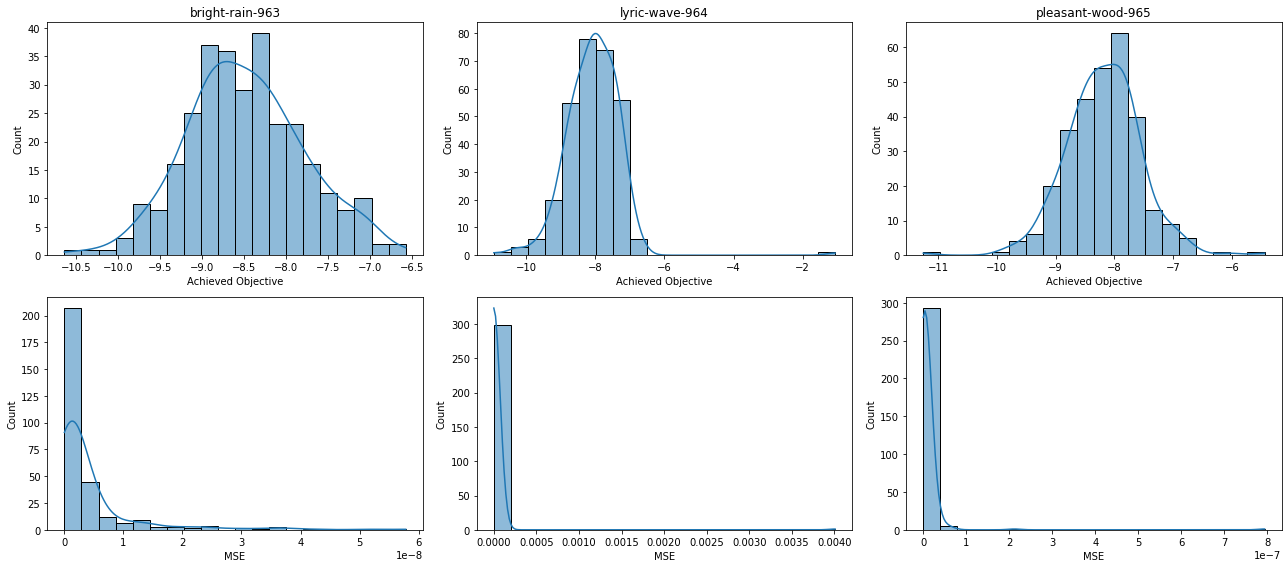

In [8]:
run_names = ["bright-rain-963", "lyric-wave-964", "pleasant-wood-965"]
objectives, mses = zip(*(evaluate(run_name, n=300) for run_name in run_names))

plt.figure(figsize=(18,8))
for i, (run_name, objective, mse) in enumerate(zip(run_names, objectives, mses)):
    plt.subplot(2, len(run_names), i+1)
    plt.title(run_name)
    sns.histplot(objective, bins=20, kde=True)
    plt.xlabel("Achieved Objective")
    plt.subplot(2, len(run_names), len(run_names)+i+1)
    sns.histplot(mse, bins=20, kde=True)
    plt.xlabel("MSE")
plt.tight_layout()
plt.show()

## Sequential with Offsets

In [11]:
run_name = "electric-universe-968"
log_dir = f"models/{run_name}"

def make_env():
    env = ARESEASequential(
        backend="simulation",
        random_incoming=True,
        random_initial=True,
        random_quadrupole_misalignments=True,
        random_screen_misalignments=True,
        beam_parameter_method="direct"
    )
    env = TimeLimit(env, max_episode_steps=50)
    env = RescaleAction(env, -1, 1)
    return env

env = DummyVecEnv([make_env])
env = VecNormalize.load(f"{log_dir}/vec_normalize.pkl", env)
env.training = False
env.norm_reward = False

model = TD3.load(f"{log_dir}/model")

Initial: [-5.86348073e-03  9.92701184e-05  3.90011413e-02  8.11970409e-04]
Achieved: [-1.65971865e+02  1.22555471e+03  6.82748355e-03  1.70466559e-03]
Desired: [-1.03158609e-03 -9.79992353e-04  8.85190906e-05  3.88803689e-04]
Delta: [ 1.65970833e+02 -1.22555569e+03 -6.73896446e-03 -1.31586191e-03]
Objective: 7.238168218768846


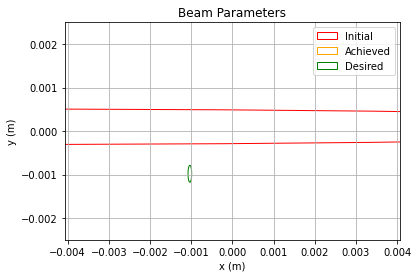

In [12]:
observation = env.reset()
desired = env.unnormalize_obs(observation)[0,-8:-4]
initial = env.unnormalize_obs(observation)[0,-4:]
done = False
while not done:
    action, _ = model.predict(observation, deterministic=True)
    observation, reward, done, info = env.step(action)
achieved = env.unnormalize_obs(info[0]["terminal_observation"])[-4:]

print("Initial:", initial)
print("Achieved:", achieved)
print("Desired:", desired)
print("Delta:", desired - achieved)
print("Objective:", env.unwrapped.envs[0].unwrapped._objective_fn(achieved, desired))

screen = env.get_attr("accelerator")[0].segment.AREABSCR1
plt.title("Beam Parameters")
plt.xlim([screen.extent[0], screen.extent[1]])
plt.ylim([screen.extent[2], screen.extent[3]])
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid()
plt.gca().add_patch(Ellipse((initial[0],initial[1]), initial[2], initial[3], fill=False, color="red", label="Initial"))
plt.gca().add_patch(Ellipse((achieved[0],achieved[1]), achieved[2], achieved[3], fill=False, color="orange", label="Achieved"))
plt.gca().add_patch(Ellipse((desired[0],desired[1]), desired[2], desired[3], fill=False, color="green", label="Desired"))
plt.legend()
plt.show()

In [13]:
def evaluate(run_name, n=100):
    log_dir = f"models/{run_name}"

    def make_env():
        env = ARESEASequential(
            backend="simulation",
            random_incoming=True,
            random_initial=True,
            random_quadrupole_misalignments=True,
            random_screen_misalignments=True,
            beam_parameter_method="direct"
        )
        env = TimeLimit(env, max_episode_steps=50)
        env = RescaleAction(env, -1, 1)
        return env

    env = DummyVecEnv([make_env])
    env = VecNormalize.load(f"{log_dir}/vec_normalize.pkl", env)
    env.training = False
    env.norm_reward = False

    model = TD3.load(f"{log_dir}/model")

    objectives = []
    mses = []
    for _ in range(n):
        observation = env.reset()
        desired = env.unnormalize_obs(observation)[0,-8:-4]
        done = False
        while not done:
            action, _ = model.predict(observation, deterministic=True)
            observation, reward, done, info = env.step(action)
        achieved = env.unnormalize_obs(info[0]["terminal_observation"])[-4:]
        objective = env.unwrapped.envs[0].unwrapped._objective_fn(achieved, desired)
        objectives.append(objective)
        mse = ((desired - achieved)**2).mean()
        mses.append(mse)
    
    return objectives, mses

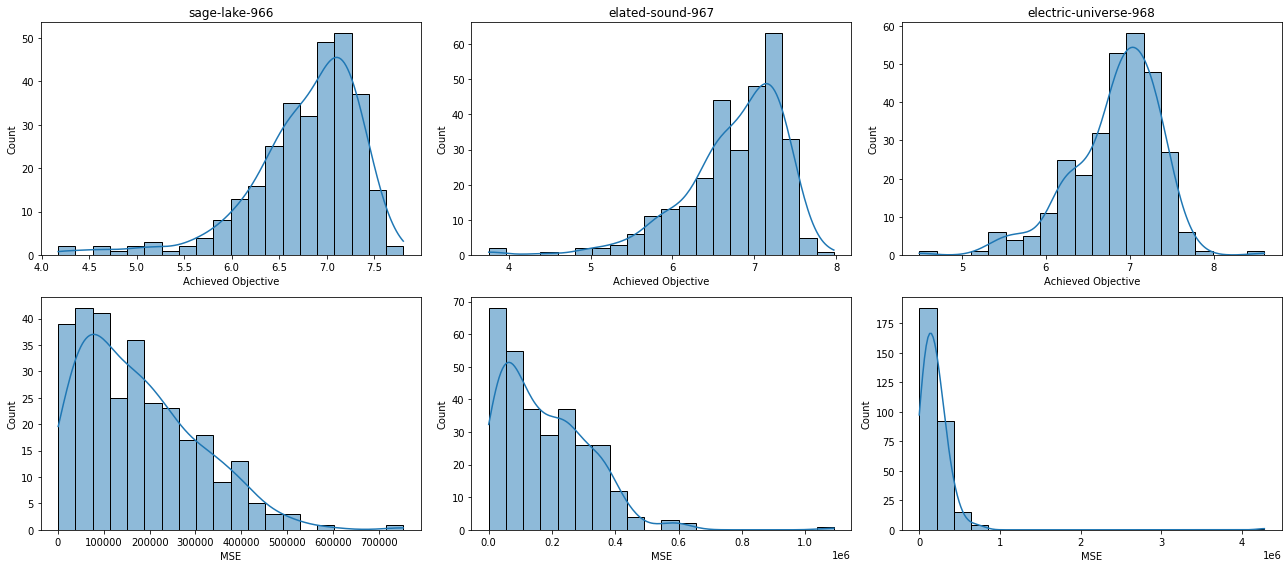

In [14]:
run_names = ["sage-lake-966", "elated-sound-967", "electric-universe-968"]
objectives, mses = zip(*(evaluate(run_name, n=300) for run_name in run_names))

plt.figure(figsize=(18,8))
for i, (run_name, objective, mse) in enumerate(zip(run_names, objectives, mses)):
    plt.subplot(2, len(run_names), i+1)
    plt.title(run_name)
    sns.histplot(objective, bins=20, kde=True)
    plt.xlabel("Achieved Objective")
    plt.subplot(2, len(run_names), len(run_names)+i+1)
    sns.histplot(mse, bins=20, kde=True)
    plt.xlabel("MSE")
plt.tight_layout()
plt.show()

## Onestep

In [2]:
run_name = "happy-snowflake-22"
log_dir = f"models/{run_name}"

def make_env():
    env = ARESEAOneStep(
        backend="simulation",
        random_incoming=True,
        random_initial=True,
        beam_parameter_method="direct"
    )
    env = RescaleAction(env, -1, 1)
    return env

env = DummyVecEnv([make_env])
env = VecNormalize.load(f"{log_dir}/vec_normalize.pkl", env)
env.training = False
env.norm_reward = False

model = PPO.load(f"{log_dir}/model")

Initial: [2.69774532e-03 7.34707143e-05 1.09930462e-03 5.86329128e-04]
Achieved: [0.00162332 0.00047872 0.00010841 0.00017327]
Desired: [1.83785715e-03 5.96448054e-04 3.08198694e-05 1.52529059e-04]
Delta: [ 2.14532199e-04  1.17728410e-04 -7.75896612e-05 -2.07437636e-05]
Objective: -7.5446596


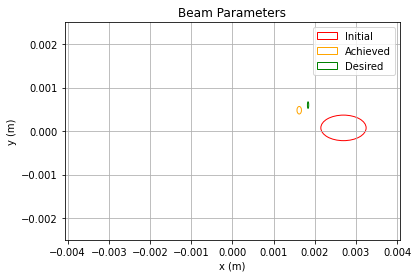

In [59]:
observation = env.reset()
desired = env.unnormalize_obs(observation)[0,-8:-4]
initial = env.unnormalize_obs(observation)[0,-4:]
action, _ = model.predict(observation, deterministic=True)
observation, reward, done, info = env.step(action)
achieved = env.unnormalize_obs(info[0]["terminal_observation"])[-4:]

print("Initial:", initial)
print("Achieved:", achieved)
print("Desired:", desired)
print("Delta:", desired - achieved)
print("Objective:", -reward[0])

screen = env.get_attr("accelerator")[0].segment.AREABSCR1
plt.title("Beam Parameters")
plt.xlim([screen.extent[0], screen.extent[1]])
plt.ylim([screen.extent[2], screen.extent[3]])
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid()
plt.gca().add_patch(Ellipse((initial[0],initial[1]), initial[2], initial[3], fill=False, color="red", label="Initial"))
plt.gca().add_patch(Ellipse((achieved[0],achieved[1]), achieved[2], achieved[3], fill=False, color="orange", label="Achieved"))
plt.gca().add_patch(Ellipse((desired[0],desired[1]), desired[2], desired[3], fill=False, color="green", label="Desired"))
plt.legend()
plt.show()

In [37]:
def evaluate(run_name, n=100):
    log_dir = f"models/{run_name}"

    def make_env():
        env = ARESEAOneStep(
            backend="simulation",
            random_incoming=True,
            random_initial=True,
            beam_parameter_method="direct"
        )
        env = RescaleAction(env, -1, 1)
        return env

    env = DummyVecEnv([make_env])
    env = VecNormalize.load(f"{log_dir}/vec_normalize.pkl", env)
    env.training = False
    env.norm_reward = False

    model = PPO.load(f"{log_dir}/model")

    objectives = []
    for _ in range(n):
        observation = env.reset()
        action, _ = model.predict(observation, deterministic=True)
        observation, reward, done, info = env.step(action)
        objectives.append(-reward[0])
    
    return objectives

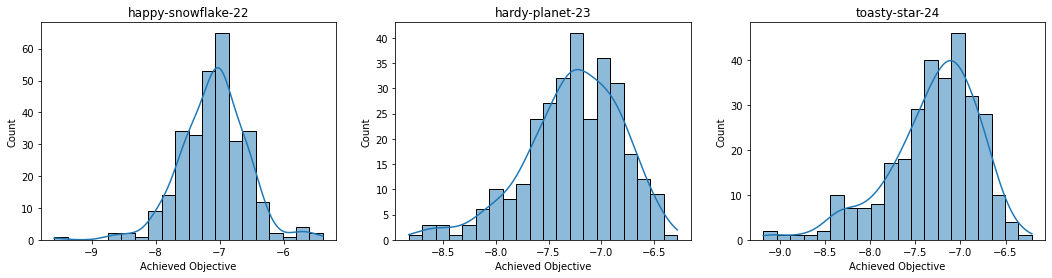

In [55]:
run_names = ["happy-snowflake-22", "hardy-planet-23", "toasty-star-24"]
results = [evaluate(run_name, n=300) for run_name in run_names]

plt.figure(figsize=(18,4))
for i, (run_name, result) in enumerate(zip(run_names, results)):
    plt.subplot(1, len(run_names), i+1)
    plt.title(run_name)
    sns.histplot(result, bins=20, kde=True)
    plt.xlabel("Achieved Objective")
plt.show()